## import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from yellowbrick.classifier import ROCAUC
from matplotlib.backends.backend_pdf import PdfPages as MatplotlibPdfPages
from matplotlib.backends.backend_pdf import PdfPages

from PyPDF2 import PdfMerger
import pandas as pd
import os


## Loading train and test datasets
The data files are stored as compressed Numpy arrays in .npz format. To load these files, we will utilize the load method from the numpy library.

In [2]:
ds_dir = "C:/Users/Sushree/Documents/kannada_mnist/Kannada_MNIST_datataset_paper/Kannada_MNIST_npz\Kannada_MNIST"

X_train = np.load(os.path.join(ds_dir,'X_kannada_MNIST_train.npz'))['arr_0']
X_test = np.load(os.path.join(ds_dir,'X_kannada_MNIST_test.npz'))['arr_0']
y_train = np.load(os.path.join(ds_dir,'y_kannada_MNIST_train.npz'))['arr_0']
y_test = np.load(os.path.join(ds_dir,'y_kannada_MNIST_test.npz'))['arr_0']

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(60000, 28, 28) (10000, 28, 28)
(60000,) (10000,)


## Creating Visualizations for the Digits Data

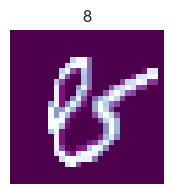

In [3]:
def plot_random_digit():
    random_index = np.random.randint(0,X_train.shape[0])
    plt.imshow(X_train[random_index], cmap='BuPu_r')
    plt.title(y_train[random_index])
    plt.axis("Off")
    
plt.figure(figsize=[2,2])
plot_random_digit()

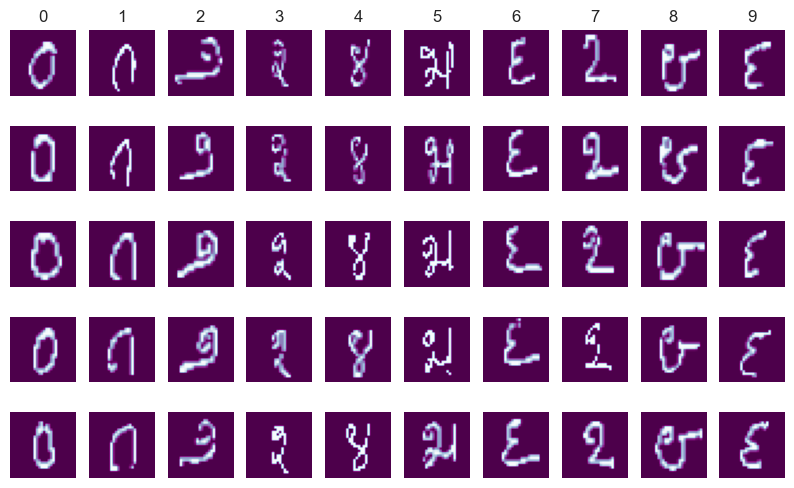

In [4]:
plt.figure(figsize=[10,6])
for i in range(50):
    plt.subplot(5, 10, i+1)
    plt.axis('Off')
    if i < 10:
        plt.title(y_train[i])
    plt.imshow(X_train[i], cmap='BuPu_r')

### function to generate a RoC - AUC curve using Yellowbrick
The ROCAUC visualizer in Yellowbrick supports multiclass classification problems by using the One-vs-Rest (OvR) strategy. It calculates the ROC curve and AUC score for each class individually and averages them to produce a micro-averaged ROC curve and AUC score.

### Perform PCA with different component sizes and evaluate each model, generating bar charts, confusion matrix heatmaps, and RoC - AUC curves:
code will iterate over different component sizes, perform PCA on the data, evaluate each model (Decision Trees, Random Forest, Naive Bayes,KNN, SVM), and generate a metrics table including Precision, Recall, F1-Score, Confusion Matrix, and RoC - AUC Curve for each model at each component size.


In [ ]:

model_names = ['Decision Trees', 'Random Forest', 'Naive Bayes', 'KNN', 'SVM']
component_sizes = [10, 15, 20, 25, 30]

precisions = {model: [] for model in model_names}
recalls = {model: [] for model in model_names}
f1_scores = {model: [] for model in model_names}

def get_classifier(model):
    if model == 'Decision Trees':
        return DecisionTreeClassifier()
    elif model == 'Random Forest':
        return RandomForestClassifier()
    elif model == 'Naive Bayes':
        return GaussianNB()
    elif model == 'KNN':
        return KNeighborsClassifier()
    elif model == 'SVM':
        return SVC()

def calculate_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    return precision, recall, f1

for size in component_sizes:
    pdf_files = []

    # Flatten the images
    X_train_flatten = X_train.reshape(X_train.shape[0], -1)
    X_test_flatten = X_test.reshape(X_test.shape[0], -1)

    # Perform PCA
    pca = PCA(n_components=size)
    X_train_pca = pca.fit_transform(X_train_flatten)
    X_test_pca = pca.transform(X_test_flatten)

    # Train and evaluate models
    for model in model_names:
        classifier = get_classifier(model)
        classifier.fit(X_train_pca, y_train)
        y_pred = classifier.predict(X_test_pca)

        # Calculate metrics
        precision, recall, f1 = calculate_metrics(y_test, y_pred)

        # Store metrics
        precisions[model].append(precision)
        recalls[model].append(recall)
        f1_scores[model].append(f1)

        # Generate metrics bar chart
        plt.figure(figsize=(8, 5))
        plt.bar(['Precision', 'Recall', 'F1-Score'], [precision, recall, f1])
        plt.ylim(0, 1)
        plt.title(f'Model Metrics - {model}')
        plt.xlabel('Metric')
        plt.ylabel('Value')
        metrics_filename = f"metrics_pca_{size}_{model}.pdf"
        with PdfPages(metrics_filename) as pdf:
            pdf.savefig()
        pdf_files.append(metrics_filename)

        # Generate confusion matrix heatmap
        plt.figure(figsize=(10, 8))
        sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
        plt.title(f'{model} - Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        confusion_matrix_filename = f"confusion_matrix_pca_{size}_{model}.pdf"
        with PdfPages(confusion_matrix_filename) as pdf:
            pdf.savefig()
        pdf_files.append(confusion_matrix_filename)

        # Generate ROC-AUC curve using Yellowbrick
        plt.figure(figsize=(10, 8))
        visualizer = ROCAUC(classifier, classes=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
        visualizer.fit(X_train_pca, y_train)
        visualizer.score(X_test_pca, y_test)
        roc_auc_filename = f"roc_auc_pca_{size}_{model}.pdf"
        visualizer.show(outpath=roc_auc_filename)
        pdf_files.append(roc_auc_filename)

    # Create model comparison table
    model_list = []
    precision_list = []
    recall_list = []
    f1_list = []

    for model in model_names:
        model_list.append(model)
        precision_list.append(precisions[model][-1])
        recall_list.append(recalls[model][-1])
        f1_list.append(f1_scores[model][-1])

    metrics_df = pd.DataFrame({
        'Model': model_list,
        'Precision': precision_list,
        'Recall': recall_list,
        'F1-Score': f1_list
    })

    # Save model comparison table to PDF
    comparison_filename = f"model_comparison_pca_{size}.pdf"
    with PdfPages(comparison_filename) as pdf:
        plt.figure(figsize=(8, 5))
        plt.axis('off')
        plt.table(
            cellText=metrics_df.values,
            colLabels=metrics_df.columns,
            cellLoc='center',
            loc='center',
        )
        plt.title(f'Model Comparison - PCA {size} components')
        pdf.savefig()
    pdf_files.append(comparison_filename)

    # Combine all individual PDF files into a single PDF file
    combined_pdf_filename = f"classification_results_pca_{size}.pdf"
    pdf_merger = PdfMerger()

    for pdf_file in pdf_files:
        pdf_merger.append(pdf_file)

    with open(combined_pdf_filename, "wb") as output_file:
        pdf_merger.write(output_file)

    pdf_merger.close()

    # Delete the individual PDF files
    for pdf_file in pdf_files:
        os.remove(pdf_file)
